# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [3]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from annoy import AnnoyIndex

from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP
from adjustText import adjust_text

In [4]:
DATA_PATH = Path('../data')
MODELS_PATH = Path('../models')

In [5]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        filtered_token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(filtered_token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
    
    def _create_sliding_window(self, window_size, stride):
        tokens_size = len(self.tokens)

        for i in range(0, tokens_size, stride):
#             center_word = islice(self.vectorized_tokens, i, i + 1)
#             left_context = islice(self.vectorized_tokens, i + 1, 
#                                   min(tokens_size, i + window_size + 1))
#             right_context = islice(self.vectorized_tokens, 
#                                    max(0, i - window_size), i)
#             yield from product(center_word, chain(left_context, right_context))

#             window_size = np.random.randint(1, max_window_size+1)
            center_word = self.vectorized_tokens[i:i+1]
            left_context = self.vectorized_tokens[max(0, i - window_size): i]
            right_context = self.vectorized_tokens[i + 1: min(tokens_size, i + window_size + 1)]
            yield from product(center_word, chain(left_context, right_context))
        
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        
    def generate_batches(self, window_size=1, stride=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size, stride)
        batch = list(zip(*islice(window, batch_size)))
        x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

        if drop_last:
            while batch and len(batch[0]) == batch_size:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
        else:
            while batch:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

In [6]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super().__init__()
        
#         self.embedding = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
#                                       embedding_dim=embedding_size), dim=1)
# #                                       max_norm=1.0)
# #                                       scale_grad_by_freq=True)
                                      
#         self.fc1 = nn.utils.weight_norm(nn.Linear(in_features=embedding_size,
#                              out_features=vocabulary_size,
#                              bias=False), dim=1)

        self.embedding = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
                                              embedding_dim=embedding_size), dim=1)

        self.fc1 = nn.utils.weight_norm(nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size,
                             bias=False), dim=1)
        
    def forward(self, x_in):
#         self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=1)
#         self.fc1.weight.data = F.normalize(self.fc1.weight.data, p=2, dim=1)
        x_embedded = self.embedding(x_in)
        y_out = self.fc1(x_embedded)
        
        return y_out

In [7]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [8]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    weights_path = MODELS_PATH/'weights.npz',
    
    embedding_size = 100,
    
    seed = 42,
    cutoff = 10, # 10
    window_size = 3, # 1
    stride = 1, # 1
    batch_size = 1024, #  1024
    learning_rate = 0.03, # 0.03
    iterations = 1000,
    save_iterations = 100,
    early_stopping_criteria = 1e8,
    factor=0.5, # 0.7
    patience=5000, # 1000
    
    cuda=True
)

In [9]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], # args.learning_rate
            'batch_idx': 0,
            'loss': [],
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['batch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

In [10]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: False


In [11]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=args.cutoff)

vocabulary_size = len(sg_batcher.vocab)
vocabulary_size

47134

In [10]:
set_seeds(args.seed)

classifier = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                                     embedding_size=args.embedding_size)
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(params=classifier.parameters(),
                      lr=args.learning_rate)

epoch_size = 2 * (args.window_size * len(sg_batcher.tokens) 
                  - np.math.factorial(args.window_size)) // (args.batch_size * args.stride)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=args.factor,
                                                 patience=args.patience)

train_bar = tqdm_notebook(desc='Training',
                          position=1,
#                           total=args.iterations,
                          total=epoch_size)

batch_generator = sg_batcher.generate_batches(window_size=args.window_size, 
                                              batch_size=args.batch_size)

train_state = make_train_state(args)

writer = SummaryWriter(log_dir='logs/task_3', comment='embedding_training')

running_loss = 0.
classifier.train()

try:
    for batch_idx, (x_batch, labels_batch) in enumerate(batch_generator, 1):
        x_batch = x_batch.to(args.device)
        labels_batch = labels_batch.to(args.device)

        optimizer.zero_grad()

        y_pred = classifier(x_in=x_batch)

        loss = loss_func(y_pred, labels_batch)
        loss_value = loss.item()
        running_loss += (loss_value - running_loss) / (batch_idx)
        loss.backward()
        
        learning_rate = optimizer.param_groups[0]['lr']
        
        train_state['batch_idx'] = batch_idx
        train_state['loss'].append(running_loss)
        train_state['learning_rate'].append(learning_rate)
#         writer.add_scalar('loss', scalar_value=loss, global_step=batch_idx)


        train_state = update_train_state(args=args,
                                         model=classifier,
                                         train_state=train_state)

        train_params = dict(loss=running_loss,
                            lr=learning_rate,
                            early_step=train_state['early_stopping_step'],
                            early_best=train_state['early_stopping_best_val'])
        train_bar.set_postfix(train_params)
        train_bar.update()
        
        optimizer.step()
        
        scheduler.step(train_state['loss'][-1])

        if train_state['stop_early'] or (batch_idx == epoch_size):
            torch.save(classifier.state_dict(), str(train_state['model_file_name']) + '_last')
            break
except KeyboardInterrupt:
    print('Exit training')

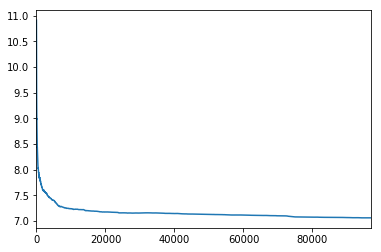

In [11]:
train_state_df = pd.DataFrame(train_state)
train_state_df['loss'].plot()
plt.show()

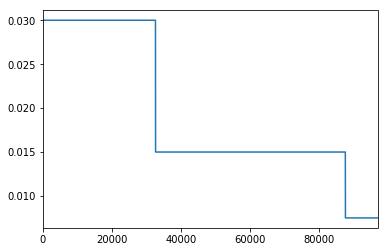

In [12]:
train_state_df['learning_rate'].plot()
plt.show()

In [12]:
state_dict = torch.load('../models/final/task_3/naive_word2vec_embeddings.pth_last', map_location='cpu')

clf = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                              embedding_size=100)
clf.load_state_dict(state_dict)
print(clf.embedding.weight_g.shape, clf.embedding.weight_v.shape)
print(clf.fc1.weight_g.shape, clf.fc1.weight_v.shape)

torch.Size([1, 100]) torch.Size([47134, 100])
torch.Size([1, 100]) torch.Size([47134, 100])


In [13]:
weights = np.load('../models/final/task_3/weights.npz')
W = weights['W']
W_prime = weights['W_prime']
W_avg = weights['W_avg']

In [14]:
metadata = list(sg_batcher.token_to_idx)

# writer.add_embedding(W, metadata=metadata, tag='W')
# writer.add_embedding(W_prime, metadata=metadata, tag='W_prime')
writer = SummaryWriter(log_dir='logs_final/task_3', comment='embedding_training')
writer.add_embedding(W_avg, metadata=metadata, tag='W_avg')

In [11]:
W.min(), W.max(), W_prime.min(), W_prime.max()

(-15.041774, 13.829485, -0.60154366, 0.5448065)

(0.06783072, 0.41869718, 0.23895663)

In [31]:
words = []
words.extend(['man', 'he', 'woman', 'she'])
words.extend(['fly', 'plane', 'aircraft', 'sail', 'ship', 'ships', 'circle'])
words.extend(['kitten', 'cat', 'puppy', 'dog'])
words.extend(['leg', 'legs', 'hand', 'hands'])
words.extend(['blue', 'color', 'dog', 'breed'])
words.extend(['toe', 'finger', 'foot', 'hand', 'arm'])
words.extend(['talk', 'communicate', 'read', 'interpret'])
words.extend(['man', 'king', 'woman', 'queen', 'doctor'])
words.extend(['man', 'doctor', 'woman', 'nurse'])
words.extend(['fast', 'fastest', 'small', 'smallest', 'rich', 'richest', 'faster', 'stronger'])
words = list(set(words))

In [25]:
def plot_embeddings(embs_reduced, token_to_idx, tokens, fig_size=(12, 12)):
    token_embs = embs_reduced[[token_to_idx[token] for token in tokens]]
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(token_embs[:, 0], token_embs[:, 1], alpha=0.3)
    
#     for i, token in enumerate(tokens):
#         ax.annotate(token, xy=(token_embs[i, 0], token_embs[i, 1]), 
#                     xytext=(token_embs[i, 0] + 0.05, token_embs[i, 1] + 0.05))
        
    texts = [plt.text(token_embs[i, 0], token_embs[i, 1], f'{token}') for i, token in enumerate(tokens)]
    adjust_text(texts)

In [19]:
%%time
pca = PCA(n_components=2, random_state=42)
embs_pca = pca.fit_transform(W_avg)

CPU times: user 420 ms, sys: 48 ms, total: 468 ms
Wall time: 122 ms


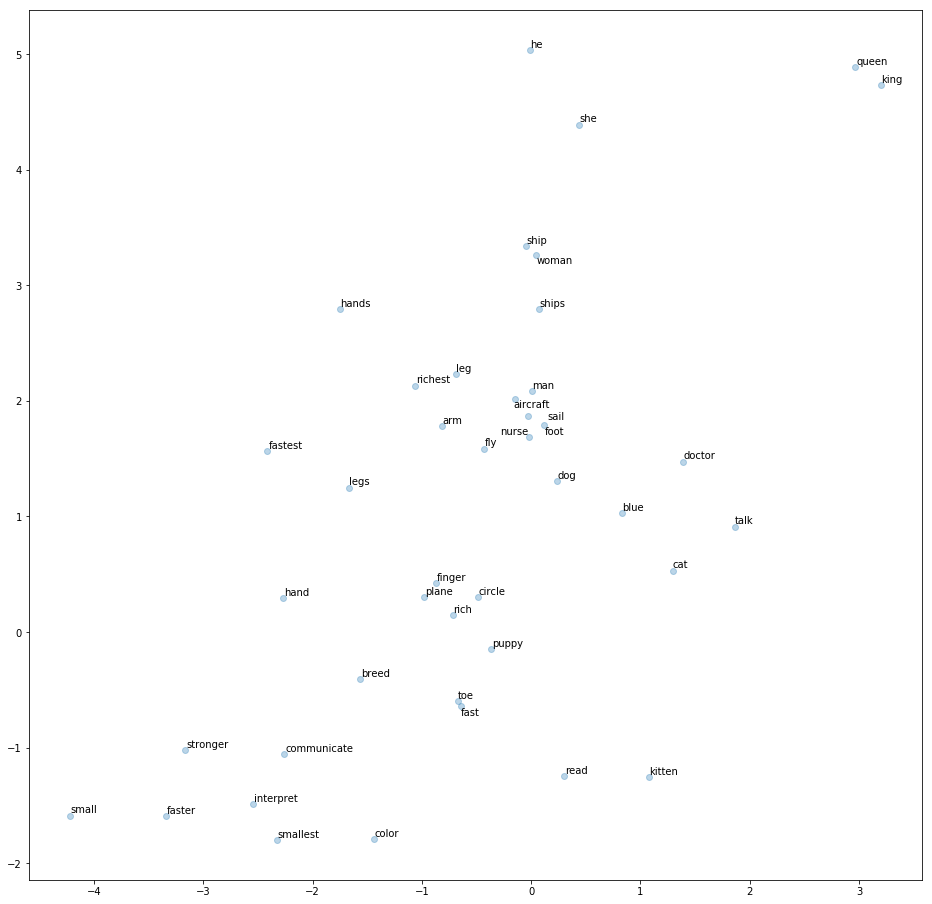

In [32]:
# tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_pca, sg_batcher.token_to_idx, words, fig_size=(16, 16))

In [21]:
%%time
tsne = TSNE(n_components=2, n_iter=1000, n_jobs=-1)
embs_tsne = tsne.fit_transform(W_avg)

CPU times: user 22min 59s, sys: 9min 26s, total: 32min 25s
Wall time: 4min 6s


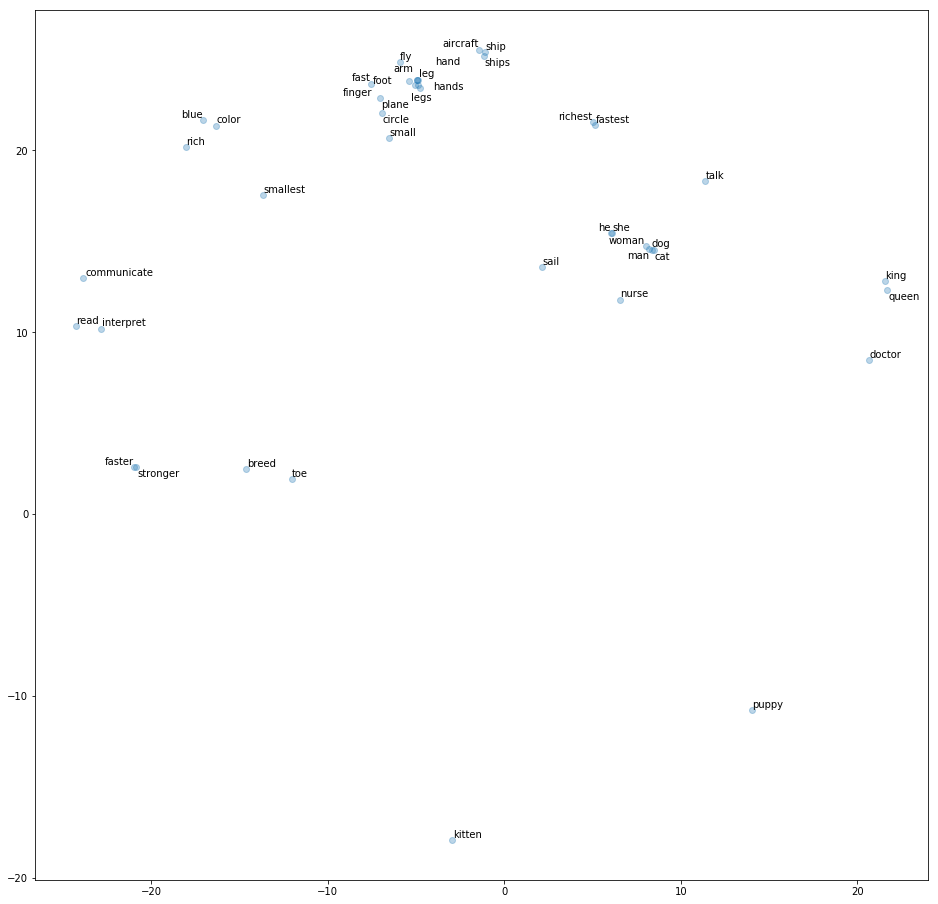

In [33]:
#tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_tsne, sg_batcher.token_to_idx, words, fig_size=(16, 16))

In [28]:
%%time
umap = UMAP(metric='cosine')
embs_umap = umap.fit_transform(W_avg)

CPU times: user 1min 57s, sys: 16.2 s, total: 2min 13s
Wall time: 1min 47s


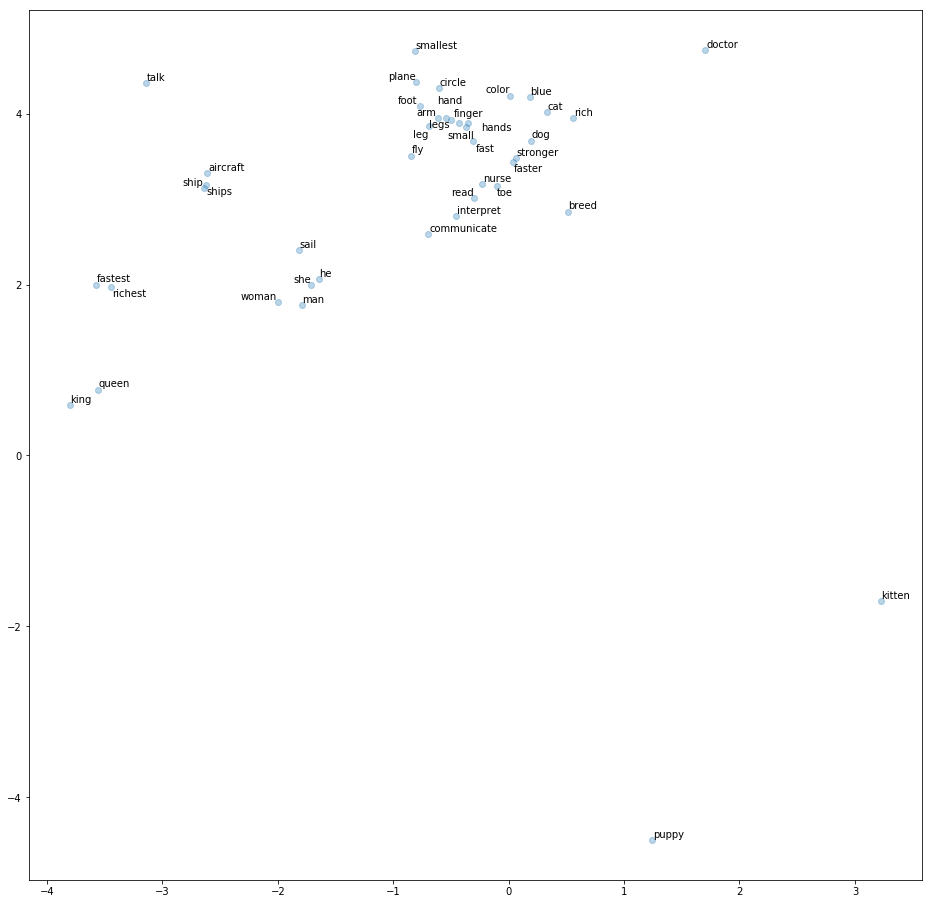

In [34]:
# tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_umap, sg_batcher.token_to_idx, words, fig_size=(16, 16))

In [141]:
class EmbeddingsExplorer():
    def __init__(self, token_to_idx, vectors, metric='euclidean'):
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx 
                             in self.token_to_idx.items()}
        self.vectors = vectors
        self.metric = metric
        
        self.index = AnnoyIndex(vectors.shape[1], metric=metric)
        
        print('Building index is started')
        for i in self.token_to_idx.values():
            self.index.add_item(i, self.vectors[i])
        
        self.index.build(50)
        print('Building index is finished')
        
    def get_embedding(self, token):
        return self.vectors[self.token_to_idx[token]]
    
    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.idx_to_token[neighbor] for neighbor in nn_indices]
    
    def compute_closest_tokens(self, target_token, n=1):
        vector = self.get_embedding(target_token)
        closest_tokens = self.get_closest_to_vector(vector, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token != target_token]
        print(f'{target_token}: {closest_tokens}')
    
    def compute_analogy(self, token1, token2, token3, n=30):
        vec1 = self.get_embedding(token1)
        vec2 = self.get_embedding(token2)
        vec3 = self.get_embedding(token3)
        vec4 = vec3 + vec2 - vec1
        
        tokens = set([token1, token2, token3])
        closest_tokens = self.get_closest_to_vector(vec4, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token not in tokens]
        
        if len(closest_tokens) == 0:
            print('Could not find nearest neighbors for the computed vector')
            return
        
#         for token4 in closest_tokens:
#             print(f'{token1}:{token2} :: {token3}:{token4}')
        
        print(f'{token1}:{token2} :: {token3}:{closest_tokens}')

In [142]:
emb_explorer = EmbeddingsExplorer(sg_batcher.token_to_idx, W_avg, metric='euclidean')
emb_explorer

Building index is started
Building index is finished


In [143]:
# man:he :: woman:(she)
emb_explorer.compute_analogy('man', 'he', 'woman')

man:he :: woman:['she', 'briefly', 'prison', 'herself', 'afterwards', 'subsequently', 'himself', 'him', 'parents', 'publicly', 'again', 'marry', 'apparently', 'secretly', 'marriage', 'succeed', 'wounded', 'reportedly', 'abroad', 'pregnant', 'allegedly', 'personally', 'her', 'consul', 'finally', 'pursue', 'resign', 'appointment', 'badly']


In [144]:
# fly:plane :: sail:(ship)
emb_explorer.compute_analogy('fly', 'plane', 'sail')

fly:plane :: sail:['circle', 'arc', 'column', 'rotation', 'outer', 'ring', 'arch', 'intersection', 'probe', 'imaginary', 'curvature', 'burst', 'mound', 'gate', 'crest', 'junction', 'columns', 'stream', 'orbital', 'loop', 'radius', 'crater', 'flux', 'triangle', 'path', 'axis', 'chain', 'segment', 'grid']


In [145]:
# fly:aircraft :: sail:(ship)
emb_explorer.compute_analogy('fly', 'aircraft', 'sail')

fly:aircraft :: sail:['missiles', 'artillery', 'submarine', 'missile', 'reconnaissance', 'infantry', 'cruise', 'tanks', 'submarines', 'tank', 'patrol', 'fighter', 'weapons', 'planes', 'jet', 'guns', 'launch', 'rocket', 'armored', 'helicopters', 'ships', 'fleet', 'operations', 'carriers', 'bomber', 'armoured', 'ballistic', 'carrier', 'missions']


In [146]:
# kitten:cat :: puppy:dog
emb_explorer.compute_analogy('kitten', 'cat', 'puppy')

kitten:cat :: puppy:['dog', 'bird', 'wolf', 'magic', 'soup', 'cow', 'devil', 'pepper', 'tiger', 'horn', 'monster', 'flower', 'dwarf', 'killer', 'beast', 'pet', 'chorus', 'honey', 'mask', 'bean', 'jacket', 'rabbit', 'grass', 'chocolate', 'grey', 'kid', 'dragon', 'eyed', 'hammer']


In [147]:
# cat:kitten :: puppy:dog
emb_explorer.compute_analogy('cat', 'kitten', 'dog')

cat:kitten :: dog:['altruistic', 'farmhouse', 'backbench', 'cheerful', 'wafers', 'wannsee', 'classmate', 'conifers', 'carpenters', 'disenfranchised', 'blasted', 'teleprinter', 'flashback', 'complexion', 'jacky', 'divergences', 'indecisive', 'pinto', 'orchids', 'trustee', 'rooting', 'replayed', 'shams', 'lind', 'lawns', 'theatrically', 'gourmet', 'pronouncement', 'believable', 'dashing']


In [148]:
# blue:color :: dog:(breed)
emb_explorer.compute_analogy('blue', 'color', 'dog')

blue:color :: dog:['breed', 'fitting', 'joke', 'straightforward', 'duplicate', 'confusing', 'perfect', 'trick', 'realistic', 'humorous', 'stupid', 'magic', 'luck', 'clip', 'melody', 'mirrors', 'puzzle', 'voice', 'meter', 'fancy', 'bunch', 'typing', 'smell', 'strange', 'creature', 'curious', 'parody', 'thread', 'pleasing']


In [149]:
# leg:legs :: hand:(hands)
emb_explorer.compute_analogy('leg', 'legs', 'hand')

leg:legs :: hand:['fingers', 'side', 'hands', 'shoulder', 'neck', 'face', 'clothes', 'surfaces', 'edges', 'bodies', 'finger', 'horns', 'teeth', 'balls', 'shoulders', 'holes', 'wooden', 'sticks', 'ingredients', 'leather', 'angles', 'stones', 'wear', 'hair', 'bones', 'eyes', 'colored', 'pulling']


In [150]:
# toe:finger :: foot:(hand)
emb_explorer.compute_analogy('toe', 'finger', 'foot')

toe:finger :: foot:['leg', 'neck', 'legs', 'arm', 'fingers', 'bottom', 'floor', 'shoulder', 'tail', 'bow', 'deck', 'edges', 'stones', 'wheel', 'rear', 'walking', 'face', 'wings', 'roof', 'front', 'plate', 'door', 'nose', 'shoulders', 'horse', 'shaft', 'vertical', 'hanging']


In [151]:
# talk:communicate :: read:(interpret)
emb_explorer.compute_analogy('talk', 'communicate', 'read')

talk:communicate :: read:['translate', 'convert', 'manipulate', 'commands', 'modify', 'integrate', 'reproduce', 'identify', 'detect', 'confuse', 'render', 'rendered', 'overcome', 'execute', 'automatically', 'checking', 'classify', 'dynamically', 'modifications', 'instructions', 'choosing', 'utilize', 'evolve', 'employ', 'correctly', 'interpret', 'proceed', 'carefully']


In [152]:
# man:king :: woman:(queen)
emb_explorer.compute_analogy('man', 'king', 'woman')

man:king :: woman:['viii', 'prince', 'son', 'vii', 'heir', 'crowned', 'henry', 'queen', 'elizabeth', 'iii', 'augustus', 'khan', 'cousin', 'daughter', 'constantine', 'princess', 'grandson', 'bishop', 'clement', 'caesar', 'aragon', 'vi', 'tsar', 'colonel', 'regent', 'alexander', 'successor', 'throne', 'innocent']


In [153]:
# man:doctor :: woman:(job title)
emb_explorer.compute_analogy('man', 'doctor', 'woman')

man:doctor :: woman:['nurse', 'secretly', 'colleague', 'lawyer', 'farmer', 'mrs', 'gertrude', 'child', 'nude', 'twins', 'stern', 'fellow', 'blonde', 'oswald', 'teenager', 'mortal', 'lover', 'reverend', 'morrison', 'servant', 'marrying', 'martha', 'emma', 'girlfriend', 'lucy', 'businessman', 'divorce', 'longtime']


In [154]:
# man:doctor :: woman:(job title)
emb_explorer.compute_analogy('woman', 'doctor', 'man')

woman:doctor :: man:['messenger', 'wizard', 'wolf', 'magic', 'detective', 'gene', 'trumpet', 'genius', 'reads', 'ape', 'morrison', 'guy', 'explores', 'clich', 'slayer', 'quotes', 'spider', 'skeptic', 'macbeth', 'depicts', 'knuth', 'barker', 'paradox', 'saga', 'mad', 'protagonist', 'recounts', 'novella']


In [155]:
# fast:fastest :: small:smallest
emb_explorer.compute_analogy('fast', 'fastest', 'small')

fast:fastest :: small:['large', 'vast', 'huge', 'substantial', 'coastal', 'growing', 'significant', 'poorest', 'outlying', 'proportion', 'comprised', 'houses', 'surrounding', 'farms', 'enclaves', 'overwhelming', 'fertile', 'comprising', 'presence', 'larger', 'neighbouring', 'richest', 'northernmost', 'comprise', 'portion', 'alpine', 'wealthiest', 'sparsely']


In [156]:
# fast:fastest :: rich:richest
emb_explorer.compute_analogy('fast', 'fastest', 'rich')

fast:fastest :: rich:['richest', 'landscape', 'wealthiest', 'poorest', 'predominant', 'sparsely', 'northeastern', 'strongest', 'principal', 'americas', 'northernmost', 'lowlands', 'uzbekistan', 'siberia', 'geological', 'coastal', 'overwhelmingly', 'abundant', 'fiji', 'highland', 'nordic', 'besides', 'mongolia', 'oldest', 'cultivated', 'ethnically', 'moreover', 'industrialized', 'punjab']


In [157]:
# fast:faster :: small:smaller
emb_explorer.compute_analogy('fast', 'faster', 'strong')

fast:faster :: strong:['stronger', 'wider', 'slower', 'weaker', 'larger', 'substantial', 'greater', 'considerably', 'broader', 'substantially', 'considerable', 'smaller', 'lighter', 'fewer', 'simpler', 'vastly', 'profound', 'powerful', 'subtle', 'heavier', 'tremendous', 'broad', 'significant', 'harder', 'gradual', 'sophisticated', 'noticeable', 'direct']


In [158]:
# right:left :: bottom:top
emb_explorer.compute_analogy('right', 'left', 'bottom')

right:left :: bottom:['edge', 'crossing', 'rolling', 'plate', 'foot', 'sits', 'floor', 'deck', 'underneath', 'ends', 'top', 'junction', 'edges', 'finger', 'pitch', 'neck', 'ridge', 'wheel', 'gate', 'facing', 'shaft', 'walking', 'drops', 'threw', 'leg', 'bow', 'reaches', 'tip', 'bend']


In [160]:
for word in words:
    emb_explorer.compute_closest_tokens(word, n=10)

hand: ['side', 'fingers', 'shoulder', 'face', 'finger', 'leg', 'neck', 'hands', 'arm']
ship: ['patrol', 'fleet', 'aboard', 'boat', 'hms', 'spacecraft', 'crew', 'vehicle', 'cruise']
sail: ['heading', 'alert', 'runway', 'throws', 'barracks', 'travelling', 'exit', 'pulls', 'kicked']
queen: ['elizabeth', 'princess', 'prince', 'anne', 'catherine', 'aragon', 'regent', 'viii', 'frederick']
foot: ['deck', 'shaft', 'bow', 'leg', 'tail', 'fingers', 'finger', 'arm', 'yard']
arm: ['leg', 'bow', 'finger', 'shoulder', 'wheel', 'thumb', 'shoulders', 'wings', 'fingers']
finger: ['bow', 'snake', 'thumb', 'rope', 'underneath', 'rolled', 'knee', 'chest', 'neck']
blue: ['yellow', 'purple', 'green', 'red', 'white', 'pink', 'bright', 'orange', 'colored']
read: ['write', 'edit', 'quote', 'learn', 'imagine', 'answers', 'suspect', 'surely', 'guess']
woman: ['child', 'herself', 'man', 'sick', 'angry', 'dog', 'wise', 'pregnant', 'widow']
stronger: ['weaker', 'heavier', 'lighter', 'safer', 'slower', 'darker', 'so

In [58]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=100000)

In [59]:
g = sg_batcher.generate_batches(window_size=5, 
                                batch_size=5)
x_batch, labels_batch = next(g)

x_batch, labels_batch

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 2, 3]))

In [60]:
vocabulary_size = len(sg_batcher.vocab)
embedding_size = 50

vocabulary_size, embedding_size

(22, 50)

In [61]:
clf = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                              embedding_size=embedding_size)

In [102]:
y_pred = clf(x_batch)
# y_pred = F.softmax(y_pred, dim=1)
y_pred

tensor([[ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.078

In [79]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [103]:
y_pred[range(5), labels_batch]

tensor([-0.7678, -0.4254,  0.3084, -0.4254,  0.3084], grad_fn=<IndexBackward>)

In [80]:
-torch.log(y_pred[range(5), labels_batch])

tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NegBackward>)

In [95]:
y_true = torch.zeros((5, vocabulary_size), dtype=torch.long)
y_true[range(5), labels_batch] = 1

In [92]:
y_true.shape, y_pred.shape

(torch.Size([5, 22]), torch.Size([5, 22]))

In [104]:
loss = nn.CrossEntropyLoss(reduce=False)
loss(y_pred, labels_batch)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NllLossBackward>)

In [64]:
arr = torch.zeros((5, vocabulary_size))
arr[range(5), labels_batch] = 1
arr.sum(dim=1)

tensor([1., 1., 1., 1., 1.])

In [65]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [70]:
loss = -np.log()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
